In [250]:
import numpy as np
import sklearn
import sklearn.datasets as ds
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
dataset = ds.fetch_kddcup99(shuffle=True)

In [5]:
data = dataset.data
data.shape

(494021, 41)

In [115]:
#find and convert categorical to one-hot numerical
categorical = []
classes = []
encodings = []
for i in range(data.shape[1]):
    if not (isinstance(data[0, i], float) or isinstance(data[0, i], int)):
        print(i, type(data[0, i]))
        categorical.append(i)
        classes.append(set(data[:, i]))
        code = {}
        j = 0
        for x in classes[-1]:
            if x not in code:
                code[x] = j
                j += 1
        encodings.append(code)

1 <class 'bytes'>
2 <class 'bytes'>
3 <class 'bytes'>


In [198]:
#one-hot encoding
idx = [i for i in range(data.shape[1]) if i not in categorical]
X = data[:, idx]
for i in range(len(categorical)):
    idx = categorical[i]
    code = encodings[i]
    Xh = np.zeros((data.shape[0], len(code)), dtype = np.float32)
    for j in range(data[:, idx].shape[0]):
        Xh[j][code[data[j, idx]]] = 1
    print(Xh[0])
    print(data[0, idx])
#     X = np.concatenate([X, Xh], axis = 1)
X = np.array(X, dtype = np.float32)
X.shape

[0. 1. 0.]
b'icmp'
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
b'ecr_i'
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
b'SF'


(494021, 38)

In [199]:
train_frac = 0.70
val_frac = 0.15
n = X.shape[0]
X_train = X[:int(n*train_frac)]
X_val = X[int(n*train_frac):int(n*(train_frac + val_frac))]
X_test = X[int(n*(train_frac + val_frac)):]
print(X_train.shape, X_val.shape, X_test.shape)

(345814, 38) (74103, 38) (74104, 38)


In [200]:
X.dtype

dtype('float32')

In [201]:
target = dataset.target
target.shape

(494021,)

In [202]:
target[:5]

array([b'smurf.', b'neptune.', b'smurf.', b'smurf.', b'smurf.'],
      dtype=object)

In [203]:
#mapping from class names to numeric labels
class_encoding = {}
i = 0
for x in target:
    if x not in class_encoding:
        class_encoding[x] = i
        i += 1
K = i

In [205]:
Y = np.zeros((target.shape[0], K))
Y.shape

(494021, 23)

In [206]:
#one-hot encoding
for i, y in enumerate(target):
    Y[i][class_encoding[y]] = 1

In [207]:
Y[:3]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]])

In [208]:
target[:3]

array([b'smurf.', b'neptune.', b'smurf.'], dtype=object)

In [209]:
n = Y.shape[0]
Y_train = Y[:int(n*train_frac)]
Y_val = Y[int(n*train_frac):int(n*(train_frac + val_frac))]
Y_test = Y[int(n*(train_frac + val_frac)):]
print(Y_train.shape, Y_val.shape, Y_test.shape)

(345814, 23) (74103, 23) (74104, 23)


In [242]:
class LDA:
    def __init__(self, data):
        #init class priors and Gaussian class conditionals
        assert type(data) == tuple
        assert len(data) == 2
        self.X = data[0]
        self.Y = data[1]
        assert self.X.shape[0] == self.Y.shape[0]
        self.d = self.X.shape[1]
        self.K = self.Y.shape[1]
        
        self.r = np.zeros((self.K, 1), dtype = np.float32)
        self.u = np.zeros((self.K, self.d), dtype = np.float32)
        self.S = np.zeros((1, self.d, self.d), dtype = np.float32)
    
    def fit(self):
        #estimate the class priors and class conditional means using sample stats
        for i in range(self.X.shape[0]):
            c = np.nonzero(self.Y[i])[0][0]
            self.r[c] += 1
            self.u[c] += self.X[i]

        self.u /= self.r 
        self.r /= self.X.shape[0]
        
        #estimate shared covariance matrix using their sample stats
        for i in range(self.X.shape[0]):
            c = np.nonzero(self.Y[i])[0][0]
            x = np.expand_dims(self.X[i], axis = 1)
            self.S[0] += np.matmul((x - self.u[c]), (x - self.u[c]).T)
        
        self.S /= (self.X.shape[0] - self.K)
    
    def predict(self, X):
        out = []
        for i in range(X.shape[0]):
            #posterior = prior * likelihood
            posteriors = [self.r[j]*stats.multivariate_normal.pdf(X[i], self.u[j], self.S[0]) for j in range(self.K)]
            pred = np.argmax(posteriors)
            out.append(pred)
        return out

In [230]:
model = LDA((X_train[:, 5:10], Y_train))
model.fit()

<Container object of 3 artists>

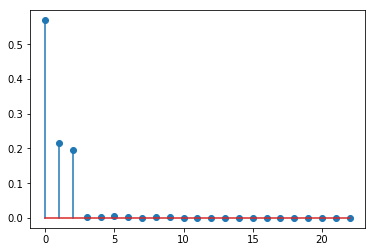

In [254]:
plt.stem(model.r)

In [232]:
w, v = np.linalg.eig(model.S[0])
w

array([2.3142845e+01, 2.9284554e+00, 7.0828281e-04, 7.9857898e-01,
       4.3319625e-01], dtype=float32)

In [236]:
Y_val_preds = model.predict(X_val[:, 5:10])

In [247]:
Y_val_n = np.zeros((Y_val.shape[0], ))
for i in range(Y_val.shape[0]):
    Y_val_n[np.nonzero(Y_val[i])[0]] = 1

In [249]:
np.nonzero(Y_val_preds == Y_val_n)[0].shape[0]/(Y_val.shape[0])

0.9986235375086029